##Importing and Setup

In [1]:
! pip install eli5
! pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107719 sha256=24f3f6ee390c3620cfc175b246278a4b5dbb324ee108d3d7fe2d422b8dcf1c5b
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 8.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import eli5
from eli5.sklearn import PermutationImportance
import shap

In [3]:
df = pd.read_csv('./retail_price.csv')
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
product_id,bed1,bed1,bed1,bed1,bed1,bed1,bed1,bed1,bed1,bed1
product_category_name,bed_bath_table,bed_bath_table,bed_bath_table,bed_bath_table,bed_bath_table,bed_bath_table,bed_bath_table,bed_bath_table,bed_bath_table,bed_bath_table
month_year,01-05-2017,01-06-2017,01-07-2017,01-08-2017,01-09-2017,01-10-2017,01-11-2017,01-12-2017,01-01-2018,01-02-2018
qty,1,3,6,4,2,3,11,6,19,18
total_price,45.95,137.85,275.7,183.8,91.9,137.85,445.85,239.94,759.81,719.82
freight_price,15.1,12.933333,14.84,14.2875,15.1,15.1,15.832727,15.23,16.533684,13.749444
unit_price,45.95,45.95,45.95,45.95,45.95,45.95,40.531818,39.99,39.99,39.99
product_name_lenght,39,39,39,39,39,39,39,39,39,39
product_description_lenght,161,161,161,161,161,161,161,161,161,161
product_photos_qty,2,2,2,2,2,2,2,2,2,2


Feature Description:


**product_id** (categorical) - detailed group subcategory name

**product_category_name**  (categorical)- broad group category name

**customers** (integer) - monthly demand for a given subcategory of goods

**month_year** (string) - data in the format (dd-mm-yyyy) within the range between 01-01-2017 and 01-08-2018. Only months and years are important here.

**qty** (integer) - monthly sales per subcategory

**total_price**(float) - montly revenue which can be calculated using formula: total_price = unit_price * qty

**unit_price** (float) - monthly unit price of subcategory good of company goods

**freight_price** (float) - freight price of the company goods

**fp1, fp2, fp3** (float) - freight price of competitors 1,2,3 goods respectively

**product_description_length** (integer) - Number of words in the subcategory description

**product_score** (float) - user rating for subcategories of the company goods

**ps1, ps2, ps3** (float) - user rating for subcategories of competitors 1,2,3 respectively

**product_photos_qty**(integer) - number of photos for each subcategory (product_id)

**product_weight_g** (integer) - unit weight in grams

**weekend** (integer) - number of weekends per month

**weekday** (integer) - number of weekdays per month

**holiday** (integer) - number of holidays per month

**year** (integer) - year which was taken from the 'month_year'

**month** (integer) - month which was taken from the 'month_year'

**comp_1, comp_2, comp_3** (float) - unit price of within the subcategory of competitors 1,2,3 goods respectively

**lag_price**- (float) - unit price on the previous month

**s**(float) - yet unknown parameter

In [4]:
df.columns

Index(['product_id', 'product_category_name', 'month_year', 'qty',
       'total_price', 'freight_price', 'unit_price', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month',
       'year', 's', 'volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2',
       'comp_3', 'ps3', 'fp3', 'lag_price'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  676 non-null    object 
 1   product_category_name       676 non-null    object 
 2   month_year                  676 non-null    object 
 3   qty                         676 non-null    int64  
 4   total_price                 676 non-null    float64
 5   freight_price               676 non-null    float64
 6   unit_price                  676 non-null    float64
 7   product_name_lenght         676 non-null    int64  
 8   product_description_lenght  676 non-null    int64  
 9   product_photos_qty          676 non-null    int64  
 10  product_weight_g            676 non-null    int64  
 11  product_score               676 non-null    float64
 12  customers                   676 non-null    int64  
 13  weekday                     676 non

In [6]:
df.product_id.unique()

array(['bed1', 'garden5', 'consoles1', 'garden7', 'health9', 'cool4',
       'health3', 'perfumery1', 'cool5', 'health8', 'garden4',
       'computers5', 'garden10', 'computers6', 'health6', 'garden6',
       'health10', 'watches2', 'health1', 'garden8', 'garden9',
       'watches6', 'cool3', 'perfumery2', 'cool2', 'computers1',
       'consoles2', 'health5', 'watches8', 'furniture4', 'watches5',
       'health7', 'bed3', 'garden3', 'bed2', 'furniture3', 'watches4',
       'watches3', 'furniture2', 'garden2', 'furniture1', 'health2',
       'garden1', 'cool1', 'computers4', 'watches7', 'computers3',
       'health4', 'watches1', 'computers2', 'bed4', 'bed5'], dtype=object)

In [7]:
df.product_category_name.unique().tolist()

['bed_bath_table',
 'garden_tools',
 'consoles_games',
 'health_beauty',
 'cool_stuff',
 'perfumery',
 'computers_accessories',
 'watches_gifts',
 'furniture_decor']

##EDA

In [8]:
df.isna().sum()

product_id                    0
product_category_name         0
month_year                    0
qty                           0
total_price                   0
freight_price                 0
unit_price                    0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_score                 0
customers                     0
weekday                       0
weekend                       0
holiday                       0
month                         0
year                          0
s                             0
volume                        0
comp_1                        0
ps1                           0
fp1                           0
comp_2                        0
ps2                           0
fp2                           0
comp_3                        0
ps3                           0
fp3                           0
lag_price                     0
dtype: int64

In [9]:
#sanity check if month year is same as given seperate month year

for index,row in df.iterrows():
  day,month,year = row['month_year'].split('-')
  if (int(month) != row.month) and (int(year) != row.year):
    print("Not matching")



In [10]:
df.columns

Index(['product_id', 'product_category_name', 'month_year', 'qty',
       'total_price', 'freight_price', 'unit_price', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month',
       'year', 's', 'volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2',
       'comp_3', 'ps3', 'fp3', 'lag_price'],
      dtype='object')

Text(0.5, 1.0, 'Customer Sales Distribution')

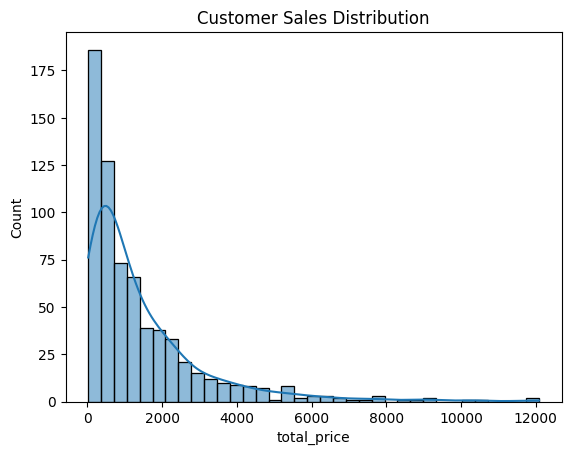

In [11]:
sns.histplot(data=df, x='total_price', kde = True)
plt.title('Customer Sales Distribution')

There are few customers buying 12000 worth of ticket size items.

Text(0.5, 1.0, 'Unit Price distribution')

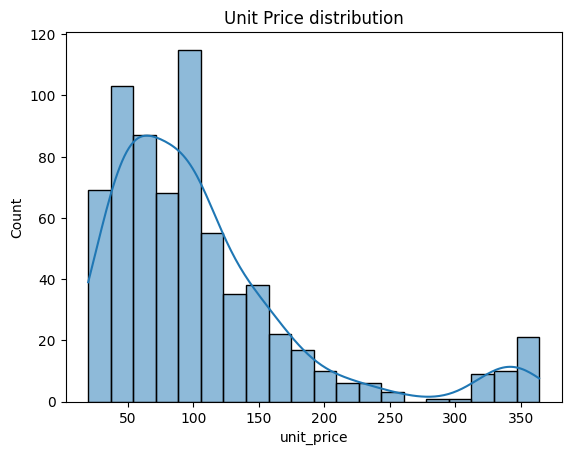

In [12]:
sns.histplot(data=df, x='unit_price', kde = True)
plt.title('Unit Price distribution')

unit price however does not exceed 350

Text(0.5, 1.0, 'Unit price w.r.t categories')

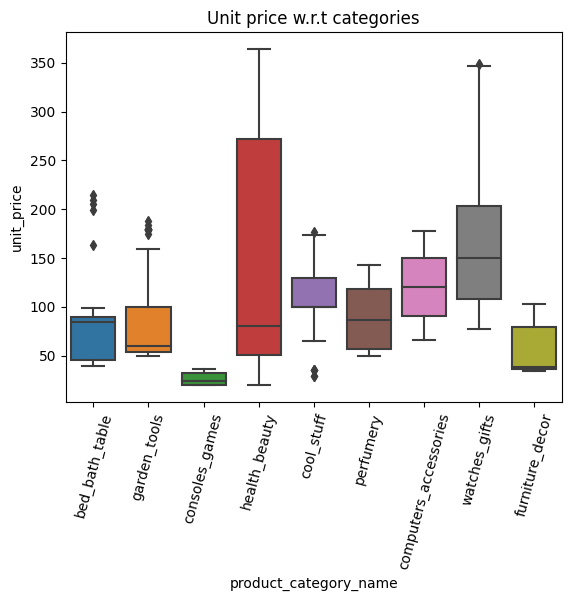

In [13]:
ax = sns.boxplot(data =df, x = 'product_category_name', y = 'unit_price')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 75)
ax.set_title('Unit price w.r.t categories')

Unit price has outliers in cool stuff, bed bath, garden tools etc.

But health and beauty price variation is the most (understandable!).

FixedFormatter should only be used together with FixedLocator


Text(0.5, 1.0, 'Total price w.r.t categories')

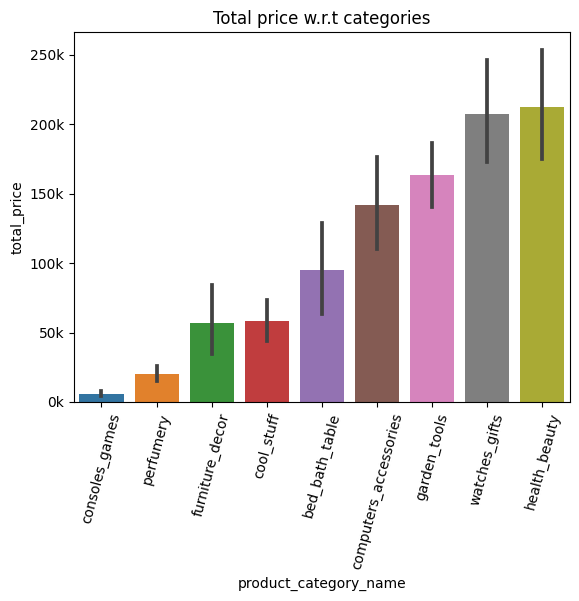

In [14]:
# total price sold wrt. categories

orderlist = df.groupby(["product_category_name"])['total_price'].aggregate(np.sum).reset_index().sort_values('total_price')
ax = sns.barplot(data =df, x = 'product_category_name', y = 'total_price', estimator = 'sum', order = orderlist['product_category_name'])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 75)
ax.set_yticklabels([str(int(i//1000))+"k" for i in ax.get_yticks()])
ax.set_title('Total price w.r.t categories')

Competitor Analysis

In [15]:
productcat = df.product_category_name.unique().tolist()

In [16]:
productcat

['bed_bath_table',
 'garden_tools',
 'consoles_games',
 'health_beauty',
 'cool_stuff',
 'perfumery',
 'computers_accessories',
 'watches_gifts',
 'furniture_decor']

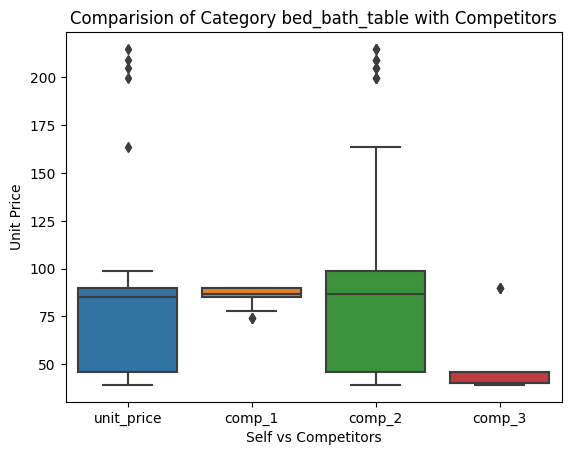

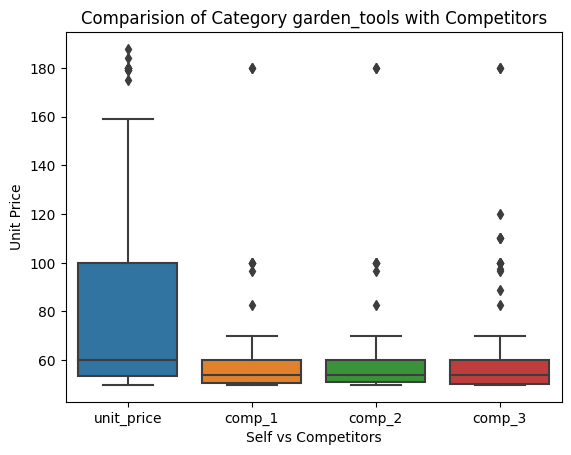

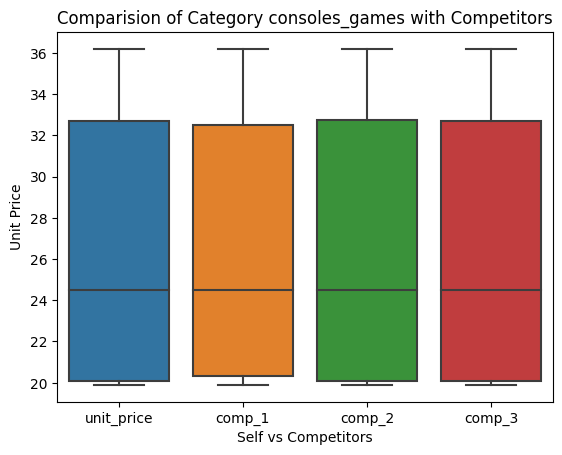

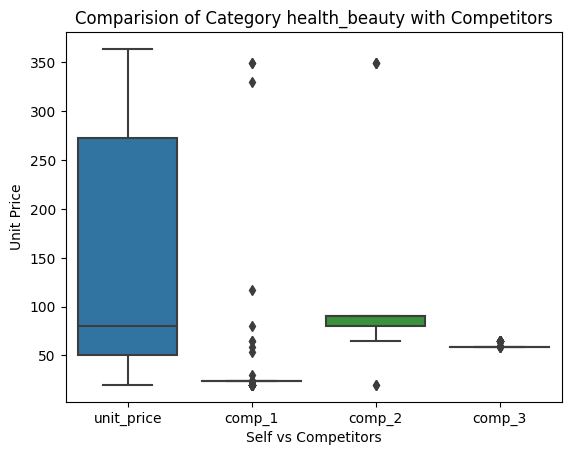

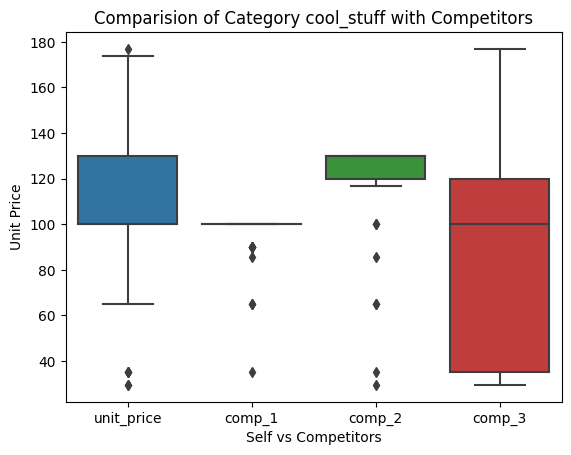

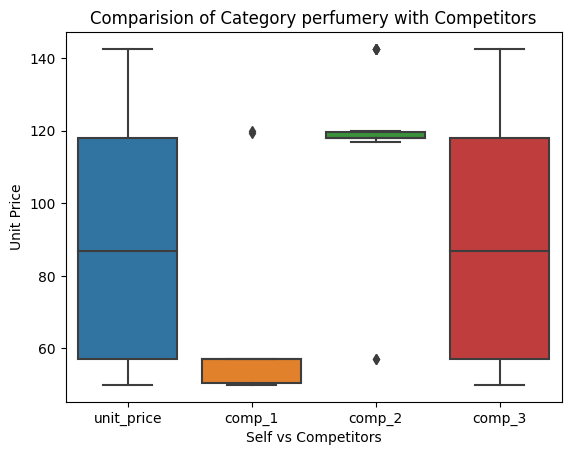

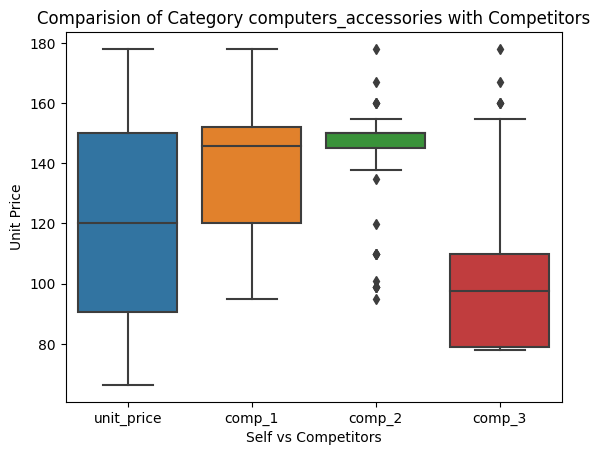

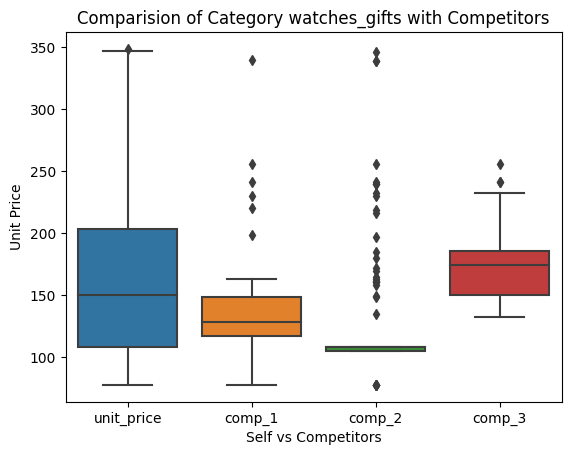

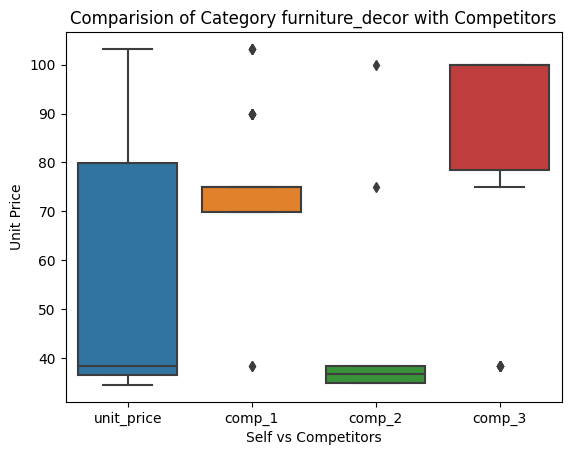

In [17]:
for category in productcat:
  dfcat = df[df['product_category_name'] == category]
  dfcat = dfcat[['unit_price', 'comp_1', 'comp_2', 'comp_3']]
  sns.boxplot(data = pd.melt(dfcat),y = 'value', x = 'variable')
  plt.xlabel('Self vs Competitors')
  plt.ylabel('Unit Price')
  plt.title(f'Comparision of Category {category} with Competitors')
  plt.show()

Correlation:

Assumptions made to not select some columns, like photos quantity, Year, etc.

Columns Selected: ['qty', 'total_price', 'freight_price', 'unit_price',
                      'product_weight_g', 'product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month','volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2',
       'comp_3', 'ps3', 'fp3', 'lag_price']

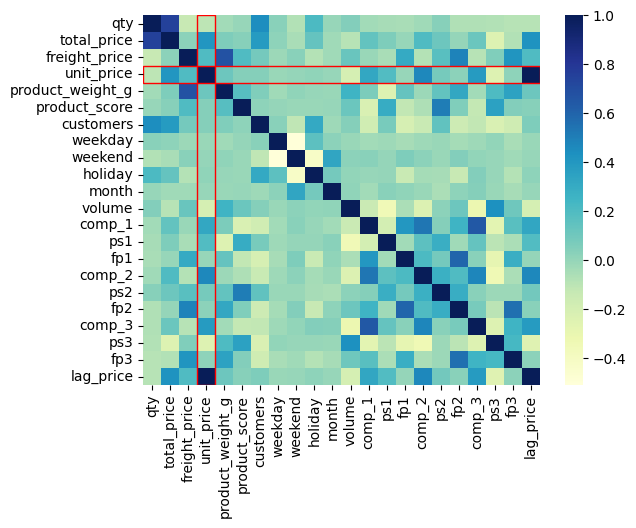

In [18]:
corrs = df[ ['qty', 'total_price', 'freight_price', 'unit_price', 'product_weight_g',
             'product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month',
             'volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2', 'comp_3',
             'ps3', 'fp3', 'lag_price']].corr()
from matplotlib.patches import Rectangle
corrplot = sns.heatmap(corrs, cmap="YlGnBu")
corrplot.add_patch(Rectangle((0,3),22,1, fill=False, edgecolor='red', lw=1))
corrplot.add_patch(Rectangle((3,0),1,22, fill=False, edgecolor='red', lw=1))

We see unit price depends more on competitor prices (exclude lag price because lag price can be calculated only when you know current unit price, which is the target variable so lag price is redundant!)

Revenue and Sales Analysis

In [19]:
def foo(x):
    m = pd.Series.mode(x);
    return m.values[0] if not m.empty else np.nan

monthly_df = df.groupby(by='month_year').agg({ 'unit_price': 'median',
'product_id':foo, 'total_price': 'sum', 'freight_price': 'mean','qty': 'sum',
  'weekday': 'mean', 'weekend': 'mean', 'customers': 'sum','comp_1':'median',
'comp_2':'median','comp_3':'median'}).reset_index()
monthly_df['month_year'] = pd.to_datetime(monthly_df['month_year'], format='%d-%m-%Y')
monthly_df = monthly_df.sort_values(by='month_year')

In [20]:
monthly_df

,month_year,unit_price,product_id,total_price,freight_price,qty,weekday,weekend,customers,comp_1,comp_2,comp_3
0,2017-01-01,207.445000,health5,2864.19,33.961250,9,22.0,9.0,18,207.445000,207.445000,64.99
2,2017-02-01,99.990000,bed2,3584.11,217.847838,35,20.0,8.0,78,89.900000,99.990000,89.90
4,2017-03-01,99.990000,bed2,10204.38,282.314965,101,23.0,8.0,242,89.900000,89.990000,99.99
6,2017-04-01,96.656667,bed2,11524.62,335.440132,121,20.0,10.0,309,89.900000,96.656667,89.90
8,2017-05-01,92.445000,bed1,21843.33,393.828633,222,23.0,8.0,803,59.900000,89.990000,64.99
10,2017-06-01,99.990000,bed1,23245.24,498.717980,233,22.0,8.0,820,89.900000,89.990000,89.00
12,2017-07-01,89.900000,bed1,41049.89,617.072993,403,21.0,10.0,1686,75.000000,89.990000,59.90
14,2017-08-01,89.990000,bed1,49550.41,670.434053,495,23.0,8.0,2279,75.000000,89.990000,59.90
16,2017-09-01,94.445000,bed1,44826.60,706.791687,450,21.0,9.0,2275,59.900000,89.990000,59.90
17,2017-10-01,92.594000,bed1,48569.38,828.531921,550,22.0,9.0,2949,75.000000,89.990000,59.90


Text(0.5, 1.0, 'Total Price vs Number of Customers')

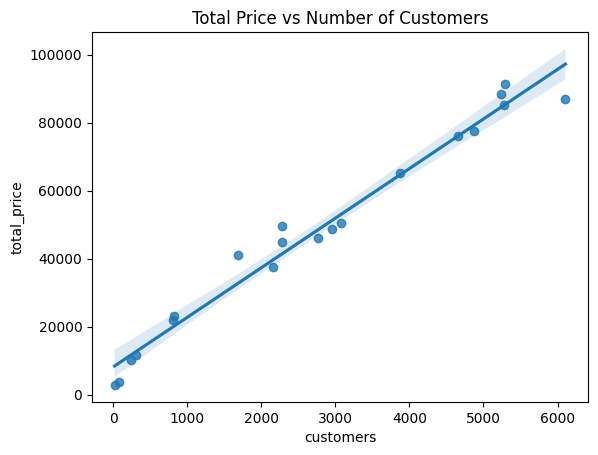

In [21]:
sns.regplot(monthly_df, x='customers', y='total_price')
plt.title('Total Price vs Number of Customers')

(array([17167., 17226., 17287., 17348., 17410., 17471., 17532., 17591.,
        17652., 17713.]),
 [Text(17167.0, 0, '2017-01'),
  Text(17226.0, 0, '2017-03'),
  Text(17287.0, 0, '2017-05'),
  Text(17348.0, 0, '2017-07'),
  Text(17410.0, 0, '2017-09'),
  Text(17471.0, 0, '2017-11'),
  Text(17532.0, 0, '2018-01'),
  Text(17591.0, 0, '2018-03'),
  Text(17652.0, 0, '2018-05'),
  Text(17713.0, 0, '2018-07')])

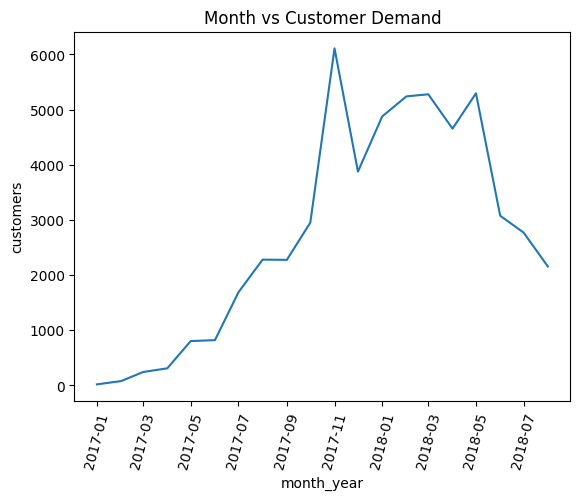

In [22]:
sns.lineplot(data=monthly_df, x = 'month_year', y = 'customers')
plt.title('Month vs Customer Demand')
plt.xticks(rotation = 75)

Feature Engineering

In [24]:
cols_to_select = ['product_id', 'comp_1', 'comp_2', 'comp_3',
                'fp1', 'fp2', 'fp3', 'product_score', 'unit_price','freight_price','customers']
products = df[cols_to_select]
products

,product_id,comp_1,comp_2,comp_3,fp1,fp2,fp3,product_score,unit_price,freight_price,customers
0,bed1,89.9,215.000000,45.95,15.011897,8.760000,15.100000,4.0,45.950000,15.100000,57
1,bed1,89.9,209.000000,45.95,14.769216,21.322000,12.933333,4.0,45.950000,12.933333,61
2,bed1,89.9,205.000000,45.95,13.993833,22.195932,14.840000,4.0,45.950000,14.840000,123
3,bed1,89.9,199.509804,45.95,14.656757,19.412885,14.287500,4.0,45.950000,14.287500,90
4,bed1,89.9,163.398710,45.95,18.776522,24.324687,15.100000,4.0,45.950000,15.100000,54
...,...,...,...,...,...,...,...,...,...,...,...
671,bed5,89.9,215.000000,45.95,15.011897,8.760000,15.100000,4.4,215.000000,8.760000,57
672,bed5,89.9,209.000000,45.95,14.769216,21.322000,12.933333,4.4,209.000000,21.322000,61
673,bed5,89.9,205.000000,45.95,13.993833,22.195932,14.840000,4.4,205.000000,22.195932,123
674,bed5,89.9,199.509804,45.95,14.656757,19.412885,14.287500,4.4,199.509804,19.412885,90


In [25]:
len(df['product_id'].unique())

52

In [26]:
strat = products['product_id'].tolist()

In [27]:
X, y = products.drop(['unit_price'], axis=1), products['unit_price']

In [28]:
from sklearn.model_selection import train_test_split
# sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=1, stratify = strat)

X_train.drop(['product_id'], axis = 1, inplace = True)
X_test.drop(['product_id'], axis = 1, inplace = True)

Model:

Since there are so many features, it might not make sense to use multiple linear regression where the relationship might not be linear at all. Therefore, Decision Trees were used to minimize the objective metric of MSE. Further, there are multiple rows for each product, therefore before splitting it is vital that we split using stratification to make even distribution of products on train and test.

In [29]:
model = RandomForestRegressor(n_estimators=50, random_state=40)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [30]:
print(f"R2 score: {r2_score(y_test, y_pred)}")

R2 score: 0.8499626692955073


In [31]:
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")

Mean Absolute Error: 15.45590487599559


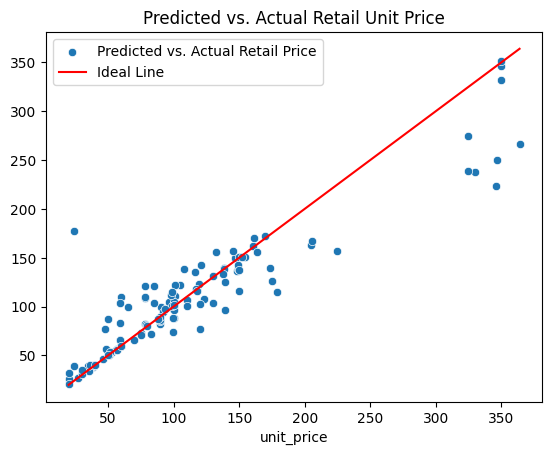

In [32]:
sns.scatterplot(x=y_test, y=y_pred, label='Predicted vs. Actual Retail Price')
plt.title('Predicted vs. Actual Retail Unit Price')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'r', label='Ideal Line')
plt.legend()
plt.show()


Explaining the model

Permutation Importance
Permutation importance is a technique for measuring the importance of features in a machine learning model. It works by shuffling the values of a single feature in the test set and measuring the decrease in performance of the model. The idea behind this is that a feature which is important for the model's prediction should have a greater impact on the model's performance when its values are randomly permuted.

In [33]:
perm = PermutationImportance(model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.7322 ± 0.1460,freight_price
0.6591 ± 0.1040,comp_2
0.4720 ± 0.0824,product_score
0.1594 ± 0.0305,comp_3
0.1417 ± 0.0103,comp_1
0.0658 ± 0.0096,fp2
0.0268 ± 0.0114,fp1
0.0152 ± 0.0048,fp3
0.0126 ± 0.0023,customers
